#**Module de requête**

#imports

In [14]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Projet SAFRAN - Module de requête
%ls

/content/drive/MyDrive/Projet SAFRAN - Module de requête
 apprentissage-bouygues/                  output_bouygues-only-originals.csv
 apprentissage-bouygues-only-originals/   photos-bouygues/
'Copie de Module de requête.ipynb'        __pycache__/
'Copie de score_matrix.csv'               request_images/
 generate_bouygues_dataset.py             request_module_functions.py
 models/                                  score_matrix.csv
'Module de requête.ipynb'                 tests-bouygues/
 output_bouygues.csv                      tests-bouygues-sample/


In [ ]:
from request_module_functions import *

In [3]:
import re
import pathlib
import numpy as np
import pandas as pd
import random 

#data augmentation imports
from skimage import data
from skimage.transform import resize, rotate
from skimage.util import random_noise
from skimage import exposure
from skimage.color import rgb2gray
import scipy.ndimage as ndimage

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset

# generate random integer values
from random import randint


def request(network, loader, optimizer, device, set_):
    network.eval()
    preds=[]
    print()
    for batch_idx, (data, target) in enumerate(loader):
        data = data.to(device)
        output = network(data)
        print(output.data)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        preds.append(pred)
    return(preds)

def request_scores(network, loader, optimizer, device, set_):
    network.eval()
    scores=[]
    #targets=[]
    for batch_idx, (data, target) in enumerate(loader):
        #target = target.to(device)
        #target_int = torch.flatten(target, start_dim=0)
        #targets.append(target)
        data = data.to(device)
        output = network(data)
        scores.append(output.cpu().data)
    return(scores)
    
def get_request_loader(folder_inputs,path_csv, request_image, transform=None):
  dataset = CustomDatasetRequest(folder_inputs,path_csv,request_image, transform)
  req_loader = torch.utils.data.DataLoader(dataset,batch_size=1,num_workers=0)
  return(req_loader)

def path_to_original(df_output,index):
  img_class=df_output['class'].values[index]
  mask = (df_output['class']==img_class) & (df_output['original_image']==True)
  return(df_output.loc[mask]['path'].values[0])

def index_of_original(df_output,index):
  img_class=df_output['class'].values[index]
  mask = (df_output['class']==img_class) & (df_output['original_image']==True)
  return(pd.Index(df_output.loc[mask])[0][0])


class CustomDatasetRequest(Dataset):
    """Segmentation & Classification dataset."""

    def __init__(self, folder_inputs,path_csv,request_image, transform=None):
        """
        Args:
            folder_outputs (string): Path to the folder with.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_output = pd.read_csv(path_csv)
        self.folder_inputs = folder_inputs
        self.request_image = request_image

        #self.inputs = self.generate_all_pairs()
        self.inputs,self.landmarks = self.generate_all_pairs()

        self.transform = transform


    def generate_all_pairs(self):
      df_output = self.data_output
      pairs = []
      output = []
      filenames = df_output['path'].values
      for i in range(len(filenames)):
          pairs.append([filenames[i], self.request_image])
          output.append(i)
      return(pairs,output)

    
    def __len__(self):
        return len(self.landmarks)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()[0]
        

        landmarks = [self.landmarks[idx]]
        image1 = plt.imread(self.folder_inputs+self.inputs[idx][0])
        image2 = plt.imread(self.inputs[idx][1])
        image2=rotate(image2, 270, resize=True)
        image2 =resize(image2 , (image1.shape[0],image1.shape[1], image1.shape[2]),anti_aliasing=True)
        
        pair = np.zeros([image1.shape[0], image1.shape[1], image1.shape[2]*2])  # 2 is for pairs
        pair[:,:,0] = image1[:,:,0]
        pair[:,:,1] = image1[:,:,1]
        pair[:,:,2] = image1[:,:,2]
        pair[:,:,3] = image2[:,:,0]
        pair[:,:,4] = image2[:,:,1]
        pair[:,:,5] = image2[:,:,2]

        landmarks = np.array([landmarks])

        if self.transform:
            pair = self.transform(pair)
            landmarks = self.transform(landmarks)
            
        return pair, landmarks

def get_dataloaders(folder_inputs,path_csv, batch_size, transform=None,size_split=[], train=True):
  dataloaders = []
  datasets = train_split_dataset(folder_inputs,path_csv, transform,size_split, train)
  train_loader = torch.utils.data.DataLoader(datasets[0], batch_size=batch_size, shuffle=True, num_workers=0)
  if train:
      return([train_loader])
  else:
      test_loader = torch.utils.data.DataLoader(datasets[1], batch_size=batch_size, shuffle=True, num_workers=0)
      return([train_loader, test_loader])

def train_split_dataset(folder_inputs,path_csv, transform=None,size_split=[], train=True):
  datasets = []
  number_indexes = len(pd.read_csv(path_csv))
  list_indexes = [i for i in range(number_indexes)]
  if train:
      train_dataset = CustomDataset(folder_inputs,path_csv,list_indexes, transform, True)
      datasets = [train_dataset]
  else:
      random.shuffle(list_indexes)

      train_indexes = list_indexes[0: int(size_split[0]*len(list_indexes))]
      test_indexes = list_indexes[int(size_split[0]*len(list_indexes)):]

      train_dataset = CustomDataset(folder_inputs,path_csv,train_indexes, transform, True)
      test_dataset = CustomDataset(folder_inputs,path_csv,test_indexes, transform, False)
      datasets = [train_dataset, test_dataset]

  return(datasets)

class CustomDataset(Dataset):
    """Segmentation & Classification dataset."""

    def __init__(self, folder_inputs,path_csv,list_indexes,ratio, transform=None, train=True):
        """
        Args:
            folder_outputs (string): Path to the folder with.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_output = pd.read_csv(path_csv)
        self.folder_inputs = folder_inputs
        self.list_indexes = list_indexes
        self.max_nb_pairs=10000
        if train:
          self.inputs, self.landmarks = self.generate_random_dataset()
        else:
          self.ratio = ratio
          self.inputs, self.landmarks = self.generate_all_pairs_with_ratio()

        self.transform = transform

    def generate_random_dataset(self):
        df_output = self.data_output.iloc[self.list_indexes, :]
        pairs = []
        output = []
        max_nb_pairs_reached=0
        max_n=self.max_nb_pairs//2
        break_2=False
        break_3=False
        for class_ in set(df_output['class'].values):
            df_int = df_output[df_output['class']==class_]
            filenames = list(df_int['path'].values)
            if break_3:
                break
            for i in range(len(filenames)):
                if break_2:
                    break
                for j in range(i+1, len(filenames)):
                    output.append(1)
                    pairs.append([filenames[i], filenames[j]])
                    if max_nb_pairs_reached>max_n:
                        break_2=True
                        break_3=True
                        break
                    max_nb_pairs_reached+=1

        filenames = list(df_output['path'].values)

        for i in range(len(pairs)):
            first_file = filenames[randint(0, len(filenames)-1)]
            class_first_file = int(df_output[df_output['path'] == first_file]['class'].values)
            list_second_file = list(df_output[df_output['class'] != class_first_file]['path'].values)
            output.append(0)
            pairs.append([first_file, list_second_file[randint(0, len(list_second_file)-1)]])
        
        return(pairs, output)

    def generate_all_pairs_with_ratio(self):
      
      pairs = []
      output = []
      
      df_output = self.data_output.iloc[self.list_indexes, :]
      filenames = df_output['path'].values
      max_pairs_per_file=math.floor(self.max_nb_pairs/len(filenames))
      max_real_pairs_per_file=math.floor(max_pairs_per_file/(1+self.ratio))

      for filename in filenames:
          class_i = df_output[df_output['path'] == filename]['class'].values[0]

          filenames_int_i = df_output[df_output['class'] == class_i]['path'].values
          add_pairs = [[filename, filename_2] for filename_2 in filenames_int_i if filename!=filename_2]

          if len(add_pairs)!=0:
              max_length=min(len(add_pairs),max_real_pairs_per_file)
              shuffle(add_pairs)
              add_pairs=add_pairs[:max_length]
              pairs += add_pairs
              output += [1 for i in range(len(add_pairs))]

              filenames_int_not_i = list(df_output[df_output['class'] != class_i]['path'].values)
              shuffle(filenames_int_not_i)
              nbr_false_to_keep = min(len(filenames_int_not_i) , int(len(add_pairs) *self.ratio))
              #print(nbr_false_to_keep)
              filenames_int_not_i = filenames_int_not_i[:nbr_false_to_keep]
              pairs += [[filename, filename_2] for filename_2 in filenames_int_not_i]
              output += [0 for i in range(nbr_false_to_keep)]


      return(pairs, output)



    def __len__(self):
        return len(self.landmarks)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()[0]
        

        landmarks = [self.landmarks[idx]]
        image1 = plt.imread(self.folder_inputs+str(self.inputs[idx][0]))
        image2 = plt.imread(self.folder_inputs+str(self.inputs[idx][1]))
        pair = np.zeros([image2.shape[0], image2.shape[1], image2.shape[2]*2])  # 2 is for pairs
        pair[:,:,0] = image1[:,:,0]
        pair[:,:,1] = image1[:,:,1]
        pair[:,:,2] = image1[:,:,2]
        pair[:,:,3] = image2[:,:,0]
        pair[:,:,4] = image2[:,:,1]
        pair[:,:,5] = image2[:,:,2]
        landmarks = np.array([landmarks])

        if self.transform:
            pair = self.transform(pair)
            landmarks = self.transform(landmarks)
            
        return pair, landmarks



class SiameseNetwork(nn.Module):
    def __init__(self, image_size, device):
        super(SiameseNetwork, self).__init__()
        self.image_size = image_size
        self.device = device
        # Layer 1
        self.conv_1 = nn.Conv2d(in_channels=self.image_size[0], out_channels= 8, kernel_size= 3,padding=1)  
        self.activation_1 = nn.ReLU()
        self.max_pooling_1 = nn.MaxPool2d((5, 5))
        self.dropout_1 = nn.Dropout(p=0.25)

        #layer 2
        self.conv_2 = nn.Conv2d(in_channels= 8, out_channels= 8, kernel_size= 3,padding=1)  
        self.activation_2 = nn.ReLU()
        self.max_pooling_2 = nn.MaxPool2d((5, 5))
        self.dropout_2 = nn.Dropout(p=0.25)

        #layer 3
        self.conv_3 = nn.Conv2d(in_channels= 8, out_channels= 8, kernel_size= 3,padding=1)  
        self.activation_3 = nn.ReLU()
        self.max_pooling_3 = nn.MaxPool2d((2, 2))
        self.dropout_3 = nn.Dropout(p=0.25)    

        # layer 4
        self.linear_4 = nn.Linear(200, 100)
        self.activation_4 = nn.ReLU()

        # layer 5: output
        self.linear_5 = nn.Linear(100, 2)

        

    def forward(self,x):
        #print('in', x.shape)
        x = x.float()
        #layer 1
        x = self.conv_1(x)
        #print('1', x.shape)
        x = self.activation_1(x)
        x = self.max_pooling_1(x)
        x = self.dropout_1(x)

        #layer 2
        x = self.conv_2(x)
        #print('2', x.shape)
        x = self.activation_2(x)
        x = self.max_pooling_2(x)
        x = self.dropout_2(x)
        
        #layer 3
        x = self.conv_3(x)
        #print('3', x.shape)
        x = self.activation_3(x)
        x = self.max_pooling_3(x)
        x = self.dropout_3(x)
        
        #layer 4
        #print('4', x.shape)
        x = x.view(x.size()[0],-1)
        x = self.linear_4(x)
        x = self.activation_4(x)
        
        #layer 5: output
        #print('5', x.shape)
        x = self.linear_5(x)
        x = F.softmax(x, dim=1)
        #print('output', x.shape)
        return  x




def test(network, loader, optimizer, device, set_):
    network.eval()
    test_loss = 0
    correct = 0
    tp=0
    fp=0
    fn=0
    tn=0

    for batch_idx, (data, target) in enumerate(loader):
        data = data.to(device)
        target = target.to(device)
        target_int = torch.flatten(target, start_dim=0)

        output = network(data)
        test_loss += F.cross_entropy(output, target_int)

        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target_int.data.view_as(pred)).cpu().sum()

        tp_,fp_,tn_,fn_=confusion(pred, target_int.data.view_as(pred))
        tp+=tp_
        fp+=fp_
        fn+=fn_
        tn+=tn_

    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    accuracy=100. * correct / (len(loader.dataset))
    test_loss /= len(loader.dataset)
    print('\n '+set_+ ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(loader.dataset),
        accuracy))
    print('\n Precision : {} and Recall : {} \n'.format(precision,recall))
    scores_dic={'accuracy':accuracy,'tp':tp,'fp':fp,'tn':tn,'fn':fn}
    return(scores_dic)

def confusion(prediction, truth):
    confusion_vector = prediction / truth

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

#Chargement du modèle

In [15]:
data_transform = transforms.Compose([transforms.ToTensor()])
dataloaders = get_dataloaders('./apprentissage-bouygues/','./output_bouygues.csv', 20, data_transform, [0.95, 0.05], False)

In [17]:
model_name='./models/best_faces.pt'

#loading the model and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print('device :',device)
loader = dataloaders[0]
lr = 0.01
network = SiameseNetwork([6,250, 250],device)
optimizer = optim.SGD(network.parameters(), lr=lr)
snapshot=torch.load(model_name,map_location='cuda:0')
#network.load_state_dict(snapshot,strict=False)
network.load_state_dict(snapshot['model_state_dict'],strict=False)
#optimizer.load_state_dict(snapshot['optimizer_state_dict'])
network.to(device)
network.eval()

device : cuda:0


SiameseNetwork(
  (conv_1): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation_1): ReLU()
  (max_pooling_1): MaxPool2d(kernel_size=(5, 5), stride=(5, 5), padding=0, dilation=1, ceil_mode=False)
  (dropout_1): Dropout(p=0.25, inplace=False)
  (conv_2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation_2): ReLU()
  (max_pooling_2): MaxPool2d(kernel_size=(5, 5), stride=(5, 5), padding=0, dilation=1, ceil_mode=False)
  (dropout_2): Dropout(p=0.25, inplace=False)
  (conv_3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation_3): ReLU()
  (max_pooling_3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout_3): Dropout(p=0.25, inplace=False)
  (linear_4): Linear(in_features=200, out_features=100, bias=True)
  (activation_4): ReLU()
  (linear_5): Linear(in_features=100, out_features=2, bias=True)
)

In [18]:
network.values

AttributeError: ignored

#Requête

In [ ]:
request_image='./tests-bouygues/Test 1/20210121_161310.jpg'
dataloader_request = get_request_loader('./apprentissage-bouygues-only-originals/','output_bouygues-only-originals.csv', request_image, data_transform)

In [ ]:
scores=request_scores(network, dataloader_request, optimizer, device, set_='test')
preds_1=[scores[i].numpy()[0][1] for i in range(len(scores))]

In [ ]:
L = [ (preds_1[i],i) for i in range(len(preds_1)) ]
L.sort(reverse=True)
images_scores,ranked_images = zip(*L)
print(ranked_images[:5])

(194, 9, 190, 95, 424)


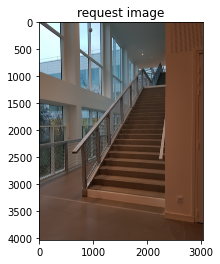

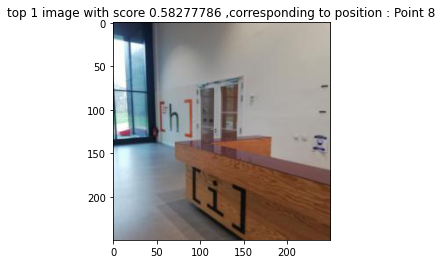

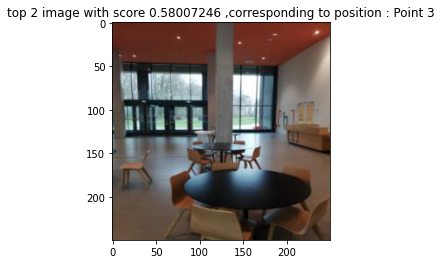

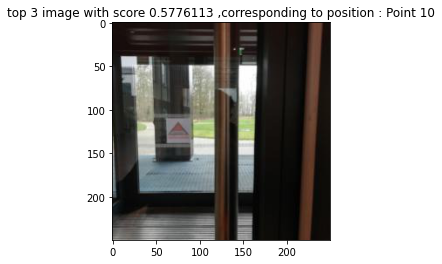

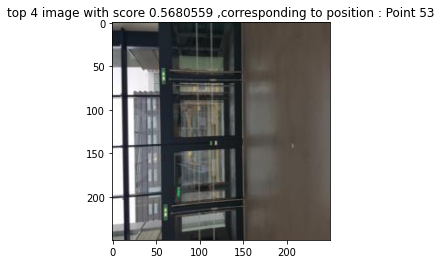

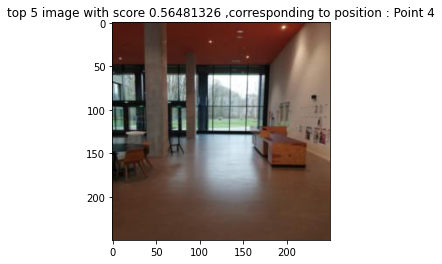

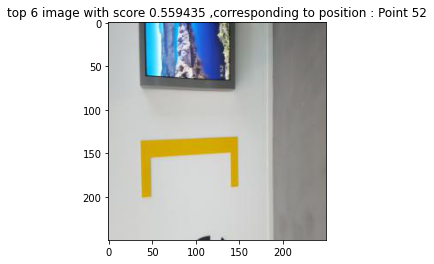

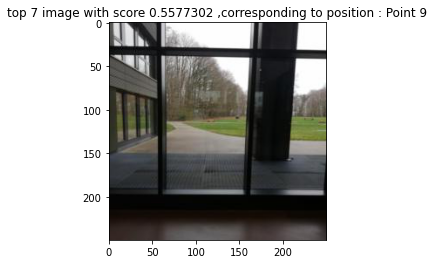

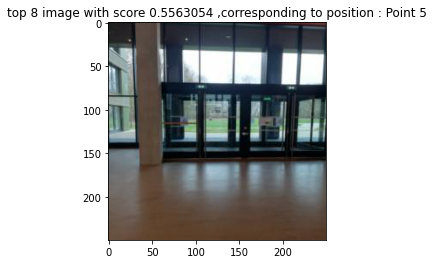

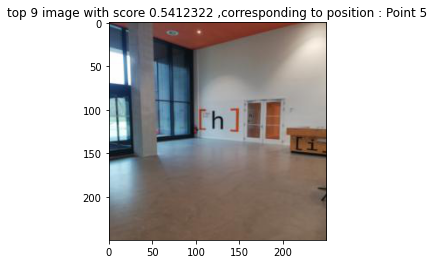

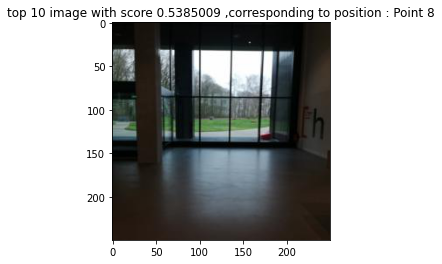

In [ ]:
top=10
df_output=pd.read_csv('output_bouygues-only-originals.csv')

plt.figure(0)
plt.title('request image')
req_img=plt.imread(request_image)
req_img=rotate(req_img, 270, resize=True)
plt.imshow(req_img)

for i in range(top):
  plt.figure(i+1)
  plt.title("top "+str(i+1)+" image with score "+str(images_scores[i])+ " ,corresponding to position : " + df_output['position'].values[ranked_images[i]])
  match_0=plt.imread('./apprentissage-bouygues-only-originals/'+df_output['path'].values[ranked_images[i]])
  plt.imshow(match_0)

#18 minutes

#Matrice de résultats

In [ ]:
import os
import pandas as pd


folder_test="./tests-bouygues-sample/"
#path vers le dossier contenant toutes les images de test

matrix_dic={}


for subdir, dirs, files in os.walk(folder_test):
    for dir in dirs:
      print(dir)
      for filename in os.listdir(folder_test+dir):
        print(filename)
        request_image = folder_test+dir+'/'+filename
        dataloader_request = get_request_loader('./apprentissage-bouygues-only-originals/','output_bouygues-only-originals.csv', request_image, data_transform)
        scores=request_scores(network, dataloader_request, optimizer, device, set_='test')
        preds_1=[scores[i].numpy()[0][1] for i in range(len(scores))] 
        matrix_dic[dir+'/'+filename]=preds_1
    df= pd.DataFrame(matrix_dic)
    df.to_csv('score_matrix.csv', index = True) 

Test 36
20210121_160704.jpg
20210121_160706.jpg
Test 1
20210121_161316.jpg
Test 60
20210121_160231.jpg
Test 62
20210121_161457.jpg
Test 22
20210121_161737.jpg


In [4]:
df_output=pd.read_csv('output_bouygues-only-originals.csv')
df = pd.read_csv('score_matrix.csv')

df_concat = pd.concat([df_output['position'],df],axis=1)

df_concat.to_csv('score_matrix.csv', index = True) 



In [ ]:
columns = df_concat.columns

for column in columns : 
  preds_1=df_concat[column]
  L = [ (preds_1[i],i) for i in range(len(preds_1)) ]
  L.sort(reverse=True)
  images_scores,ranked_images = zip(*L)
  print(ranked_images[:5])

In [12]:
columns = df_concat.columns
df_ranked=pd.DataFrame({})
for column in columns[2:]:
  preds_1=df_concat[column]
  L = [ (preds_1[i],i) for i in range(len(preds_1)) ]
  L.sort(reverse=True)
  images_scores,ranked_images = zip(*L)
  df_ranked[column] = [df_output['position'].values[ranked_images[i]] for i in range(len(ranked_images))]
df_ranked.to_csv('ranks_matrix.csv', index = True) 